In [3]:
import sys
sys.path.append('../notebooks')
import utils
import os
import numpy as np
import glob
import cv2
import utils
import skimage
import pylab as pl
import shutil
import matplotlib.cm as cm
from sklearn.cross_validation import train_test_split
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning, module='.*/ipykernel/.*')
%matplotlib inline

/home/julien/kaggle/venv/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/home/julien/kaggle/venv/local/lib/python2.7/site-packages/ipykernel/pylab/config.py:66: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  inline backend."""
/home/julien/kaggle/venv/local/lib/python2.7/site-packages/ipykernel/pylab/config.py:71: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  'retina', 'jpeg', 'svg', 'pdf'.""")
/home/julien/kaggle/venv/local/lib/python2.7/site-packages/ipykernel/pylab/config.py:85: DeprecationWarning: metadata {'config': True} was set f

In [4]:
_d = np.load('../data/data_128_train.npz')
X = _d['X']
Y = _d['Y']
X_pids = _d['pids']

# Turn labels into boolean present/missing
Y_binary = np.sum(np.sum(Y, axis=2), axis=1) > 0
Y_binary = Y_binary.astype(np.float32)

In [5]:
print X.shape
print Y.shape
print X.dtype
print Y.dtype

(5635, 128, 128)
(5635, 128, 128)
float32
float32


In [6]:
if True:
    # Split patients in train/test
    train_pids, test_pids = train_test_split(np.unique(X_pids), test_size=0.1)
    print train_pids
    print test_pids
    
    train_indices = np.flatnonzero(np.in1d(X_pids, train_pids))
    test_indices = np.flatnonzero(np.in1d(X_pids, test_pids))
    X_train = X[train_indices][:,None,:,:]
    Y_train_binary = Y_binary[train_indices][:,None]
    Y_train = Y[train_indices][:,None,:,:]
    X_test = X[test_indices][:,None,:,:]
    Y_test_binary = Y_binary[test_indices][:,None]
    Y_test = Y[test_indices][:,None,:,:]
else:
    nsamples = X.shape[0]

    #train_indices, test_indices = train_test_split(np.arange(nsamples), test_size=0.1)
    train_indices, test_indices = train_test_split(np.arange(nsamples), test_size=0.1)
    X_train = X[train_indices][:,None,:,:]
    Y_train_binary = Y_binary[train_indices][:,None]
    Y_train = Y[train_indices][:,None,:,:]
    X_test = X[test_indices][:,None,:,:]
    Y_test_binary = Y_binary[test_indices][:,None]
    Y_test = Y[test_indices][:,None,:,:]

[34 30 32 47 43 39 36 14 35 38  9 45 17 19 11 13  5 22  3 33 16 28 31 21 44
  4 27 12 29 41 40 26  2  1 10 15 37 18  8 46 42 23]
[25  7 20  6 24]


In [7]:
if False:
    # Only select images with masks
    train_mask = Y_train_binary > 0.5
    X_train = X_train[train_mask][:,None,:,:]
    Y_train = Y_train[train_mask][:,None,:,:]
    test_mask = Y_test_binary > 0.5
    X_test = X_test[test_mask][:,None,:,:]
    Y_test = Y_test[test_mask][:,None,:,:]

In [8]:
import skimage.transform as sktransf

def rand_float(rng):
    return rng[0] + np.random.random() * (rng[1] - rng[0])

def generate_image(X_img, Y_img, angle_range=None, zoom_range=None, shear_range=None, horiz_shift_range=None,
                   vert_shift_range=None):
    """
    Randomly shift an image by resizing and then random croping
    the resized image
    """
    if angle_range is None:
        angle_range = (-5, 5)
    if zoom_range is None:
        zoom_range = (0.8, 1.2)
    if shear_range is None:
        shear_range = (-5, 5) # shear angle in degrees
    if horiz_shift_range is None:
        horiz_shift_range = (-5, 5)
    if vert_shift_range is None:
        vert_shift_range = (-5, 5)
    inshape = X_img.shape
    
    X2 = X_img.copy()
    Y2 = Y_img.copy()
    
    # -- random rotation
    angle = np.deg2rad(rand_float(angle_range))
    zoom = rand_float(zoom_range)
    shear = np.deg2rad(rand_float(shear_range))
    horiz_shift = rand_float(horiz_shift_range)
    vert_shift = rand_float(vert_shift_range)
    
    tform = sktransf.AffineTransform(
        scale=(zoom, zoom),
        rotation=angle,
        shear=shear,
        translation=(horiz_shift, vert_shift)
    )
    X2 = sktransf.warp(X2, tform, order=5, mode='edge')
    Y2 = sktransf.warp(Y2, tform, order=1)

    # gaussian noise
    #noise_scale = rand_float((0, 0.1))
    #X2 += np.random.normal(scale=noise_scale, size=X2.shape)
    Y2 = Y2 > 0.5
    return X2[None,:,:].astype(np.float32), Y2[None,:,:].astype(np.float32)

X_train_augmented = []
Y_train_augmented = []
for i in range(X_train.shape[0]):
    if i % 10 == 0:
        print '\r%d / %d' % (i, X_train.shape[0]),
        sys.stdout.flush()
    X_train_augmented.append(X_train[i])
    Y_train_augmented.append(Y_train[i])
    if False:
        for j in range(2):
            X2, Y2 = generate_image(X_train[i].squeeze(), Y_train[i].squeeze())
            X_train_augmented.append(X2)
            Y_train_augmented.append(Y2)

5030 / 5036


In [9]:
X_train = np.array(X_train_augmented, dtype=np.float32)
Y_train = np.array(Y_train_augmented, dtype=np.float32)

Y_train_binary = np.sum(np.sum(Y_train, axis=2), axis=2) > 0
Y_train_binary = Y_train_binary.astype(np.float32)

print X_train.shape
print Y_train.shape
print X_test.shape
print X_train.min(), X_train.max()

(5036, 1, 128, 128)
(5036, 1, 128, 128)
(599, 1, 128, 128)
0.0 1.0


In [10]:
# Draw elipsis on image
def find_ellipse(mask, draw=True):
    mask = skimage.img_as_ubyte(mask.squeeze())
    ret, thresh = cv2.threshold(mask, 127, 255, 0)
    contours, hierarchy = cv2.findContours(thresh, 1, 2)
    has_ellipse = len(contours) > 0
    ellipse = None
    if has_ellipse:
        if len(contours) > 1:
            # select largest contour
            areas = [cv2.contourArea(cnt) for cnt in contours]
            cnt = contours[np.argmax(areas)]
        else:
            cnt = contours[0]
        ellipse = cv2.fitEllipse(cnt)
        
    return has_ellipse, ellipse

def draw_ellipse(ellipse):
    img = np.zeros((128, 128, 3), dtype=np.uint8)
    cx, cy = ellipse[0]
    ax, ay = ellipse[1]
    angle = ellipse[2]
    # need to make all parameters int otherwise fallback on the ellipse(box) one
    cv2.ellipse(img, (int(cx), int(cy)), (int(ax/2), int(ay/2)), int(angle), 0, 360, (0, 255, 0), 1)
    return img

/home/julien/kaggle/venv/local/lib/python2.7/site-packages/skimage/util/dtype.py:110: UserWarning: Possible precision loss when converting from float32 to uint8
  "%s to %s" % (dtypeobj_in, dtypeobj))


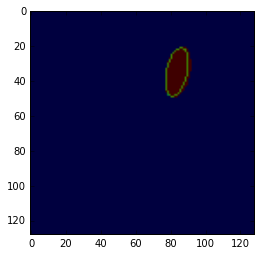

In [11]:
i = 2
has_ellipse, ellipse = find_ellipse(Y_train[i].squeeze())

overlay = draw_ellipse(ellipse)
pl.imshow(Y_train[i].squeeze())
pl.imshow(overlay, alpha=0.5)

In [12]:
X_train_with_masks = X_train[Y_train_binary > 0][:,None,:,:]
Y_train_with_masks = Y_train[Y_train_binary > 0]
X_test_with_masks = X_test[Y_test_binary > 0][:,None,:,:]
Y_test_with_masks = Y_test[Y_test_binary > 0]
print X_train_with_masks.shape
print X_test_with_masks.shape

(2040, 1, 128, 128)
(283, 1, 128, 128)


In [13]:
def build_ellipse_ds(Y):
    Y_ellipse = []
    for i in range(Y.shape[0]):
        has_ellipse, ellipse = find_ellipse(Y[i].squeeze())
        assert has_ellipse
        cx, cy = ellipse[0]
        ax, ay = ellipse[1]
        angle = ellipse[2]
        # Make cx, cy and ax, ay percentage of image size from center (so it is in -1, 1)
        Y_ellipse.append((
            (cx - 64) / 64.0,
            (cy - 64) / 64.0,
            # ax will be a difference to the base lenght of 16
            (ax - 16) / 32,
            (ay - 16) / 32,
            (angle - 180) / 180.))
    return np.array(Y_ellipse)

Y_train_ellipses = build_ellipse_ds(Y_train_with_masks)
Y_test_ellipses = build_ellipse_ds(Y_test_with_masks)

print Y_train_ellipses.shape

(2040, 5)


# Keras model to predict mask presence

In [14]:
# channels first in keras
input_shape = X_train[0].shape
print input_shape

(1, 128, 128)


In [15]:
os.environ['KERAS_BACKEND'] = 'theano'
# TODO: Use float16 ?
os.environ['THEANO_FLAGS'] = 'mode=FAST_RUN,device=gpu0,floatX=float32'
import keras
from keras.layers import Input, Dense, Dropout, Activation, Flatten, merge, RepeatVector, Permute, Reshape
from keras.layers import Convolution2D, MaxPooling2D, UpSampling2D, MaxoutDense
from keras.layers import LeakyReLU, BatchNormalization
from keras.models import Model
from keras.optimizers import SGD, RMSprop
from keras.utils.layer_utils import print_summary
from keras.models import model_from_json
from keras.callbacks import ModelCheckpoint
import keras.backend as K
import theano
print theano.config.device

Using Theano backend.


gpu0


Using gpu device 0: GeForce GTX 960 (CNMeM is disabled, cuDNN 4007)


In [16]:
from keras.layers import Layer, InputSpec
import keras.initializations
import keras.backend as K

class Maxout2D(Layer):
    def __init__(self, output_dim, cardinality, init='glorot_uniform', **kwargs):
        super(Maxout2D, self).__init__(**kwargs)
        # the k of the maxout paper
        self.cardinality = cardinality
        # the m of the maxout paper
        self.output_dim = output_dim
        self.init = keras.initializations.get(init)
    
    def build(self, input_shape):
        self.input_dim = input_shape[1]
        self.input_spec = [InputSpec(dtype=K.floatx(),
                                     shape=(None, input_shape[1], input_shape[2], input_shape[3]))]
        self.W = self.init((self.input_dim, self.output_dim, self.cardinality),
                           name='{}_W'.format(self.name))
        self.b = K.zeros((self.output_dim, self.cardinality))
        self.trainable_weights = [self.W, self.b]
              
    def call(self, x, mask=None):
        input_shape = self.input_spec[0].shape
        # flatten the spatial dimensions
        flat_x = K.reshape(x, (-1, input_shape[1], input_shape[2] * input_shape[3]))
        output = K.dot(
            K.permute_dimensions(flat_x, (0, 2, 1)),
            K.permute_dimensions(self.W, (1, 0, 2))
        )
        output += K.reshape(self.b, (1, 1, self.output_dim, self.cardinality))
        output = K.max(output, axis=3)
        output = output.transpose(0, 2, 1)
        output = K.reshape(output, (-1, self.output_dim, input_shape[2], input_shape[3]))
        return output
    
    def get_output_shape_for(self, input_shape):
        return (input_shape[0], self.output_dim, input_shape[2], input_shape[3])
    
    def get_config(self):
        config = {
            'output_dim': self.output_dim,
            'cardinality': self.cardinality
        }
        base_config = super(Maxout2D, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [17]:
input_img = x = Input(shape=input_shape, name='input_img')
x = Dropout(0.25)(x)
x = Convolution2D(32, 3, 3, border_mode='same')(input_img)
x = Convolution2D(16, 3, 3, border_mode='same')(x)
x = Maxout2D(16, 2)(x)
pool1 = x = MaxPooling2D((2, 2), name='pool1')(x)

x = Dropout(0.25)(x)
x = Convolution2D(32, 3, 3, border_mode='same')(x)
x = Convolution2D(16, 3, 3, border_mode='same')(x)
x = Maxout2D(16, 2)(x)
pool2 = x = MaxPooling2D((2, 2), name='pool2')(x)

x = Dropout(0.25)(x)
x = Convolution2D(32, 3, 3, border_mode='same')(x)
x = Convolution2D(16, 3, 3, border_mode='same')(x)
x = Maxout2D(16, 2)(x)
pool3 = x = MaxPooling2D((2, 2), name='pool3')(x)

x = Dropout(0.25)(x)
x = Convolution2D(16, 3, 3, border_mode='same')(x)
x = Convolution2D(16, 3, 3, border_mode='same')(x)
x = Maxout2D(16, 2)(x)
pool4 = x = MaxPooling2D((2, 2), name='pool4')(x)

x = Dropout(0.25)(x)
x = Convolution2D(16, 3, 3, border_mode='same')(x)
x = Convolution2D(16, 3, 3, border_mode='same')(x)
x = Maxout2D(16, 2)(x)
pool5 = x = MaxPooling2D((2, 2), name='pool5')(x)

x = Flatten()(pool5)
x = Dense(128)(x)
x = LeakyReLU(0.3)(x)
x = Dense(128)(x)
x = LeakyReLU(0.3)(x)
outellipse = Dense(5, activation='tanh', name='outellipse')(x)

model = Model(
    input=input_img,
    output=outellipse
)

#sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
#model.compile(optimizer=sgd, loss='binary_crossentropy')
#rmsprop = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08)
#model.compile(optimizer=rmsprop, loss='binary_crossentropy')
model.compile(optimizer='adam', loss='mse')

print_summary(model.layers)

____________________________________________________________________________________________________
Layer (type)                       Output Shape        Param #     Connected to                     
input_img (InputLayer)             (None, 1, 128, 128) 0                                            
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)    (None, 32, 128, 128)320         input_img[0][0]                  
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)    (None, 16, 128, 128)4624        convolution2d_1[0][0]            
____________________________________________________________________________________________________
maxout2d_1 (Maxout2D)              (None, 16, 128, 128)544         convolution2d_2[0][0]            
___________________________________________________________________________________________

In [18]:
if True:
    json_string = model.to_json()
    open('architecture.json', 'w').write(json_string)
    
    model_checkpoint = ModelCheckpoint('weights.hdf5', monitor='val_loss', save_best_only=True, verbose=True)
    
    history = model.fit(
        X_train_with_masks, Y_train_ellipses,
        batch_size=64,
        validation_data=(X_test_with_masks, Y_test_ellipses),
        nb_epoch=60,# 40 + 10 + 10 + 5 + 5
        verbose=1,
        shuffle=True,
        #callbacks=[model_checkpoint]
    )
    
    pl.figure()
    pl.plot(history.history['acc'], label='train acc')
    pl.plot(history.history['val_acc'], c='g', label='val acc')
    pl.legend()
else:
    model_dir = '.'
    model = model_from_json(
        open(os.path.join(model_dir, 'architecture.json')).read(),
                custom_objects={'Maxout2D' : Maxout2D}
    )
    model.load_weights(os.path.join(model_dir, 'weights.hdf5'))
    model.compile(optimizer='adam', loss='binary_crossentropy',
                  loss_weights=[1., 0.01])
    
    print_summary(model.layers)

Train on 2040 samples, validate on 283 samples
Epoch 1/60
2040/2040 [==============================] - 23s - loss: 0.4961 - val_loss: 0.0647
Epoch 2/60
2040/2040 [==============================] - 23s - loss: 0.0849 - val_loss: 0.1345
Epoch 3/60
2040/2040 [==============================] - 23s - loss: 0.0519 - val_loss: 0.1218
Epoch 4/60
2040/2040 [==============================] - 23s - loss: 0.0485 - val_loss: 0.0914
Epoch 5/60
2040/2040 [==============================] - 23s - loss: 0.0474 - val_loss: 0.0670
Epoch 6/60
2040/2040 [==============================] - 23s - loss: 0.0471 - val_loss: 0.0750
Epoch 7/60
2040/2040 [==============================] - 23s - loss: 0.0472 - val_loss: 0.0539
Epoch 8/60
2040/2040 [==============================] - 23s - loss: 0.0466 - val_loss: 0.0481
Epoch 9/60
2040/2040 [==============================] - 23s - loss: 0.0454 - val_loss: 0.0480
Epoch 10/60
2040/2040 [==============================] - 23s - loss: 0.0450 - val_loss: 0.0428
Epoch 11/60


KeyboardInterrupt: 

In [19]:
Y_pred_ellipses = model.predict(X_test_with_masks)

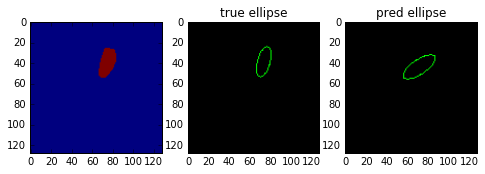

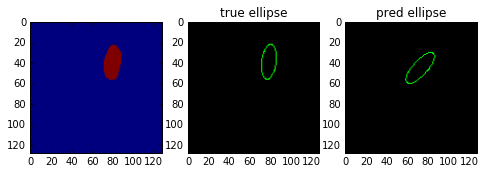

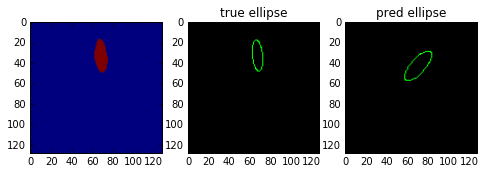

In [24]:
def draw_normalized_ellipse(Y):
    cx = 64 * Y[0] + 64
    cy = 64 * Y[1] + 64
    ax = 32 * Y[2] + 16
    ay = 32 * Y[3] + 16
    angle = 180 * Y[4] + 180
    return draw_ellipse([(cx, cy), (ax, ay), angle])

for i in np.random.choice(X_test_with_masks.shape[0], 3, replace=False):
    pl.figure(figsize=(8, 3))
    pl.subplot(131)
    pl.imshow(Y_test_with_masks[i])
    pl.subplot(132)
    pl.title('true ellipse')
    pl.imshow(draw_normalized_ellipse(Y_test_ellipses[i]))
    pl.subplot(133)
    pl.title('pred ellipse')
    pl.imshow(draw_normalized_ellipse(Y_pred_ellipses[i]))